In [1]:
# @title Install pytorchfire and dependencies

%pip install pytorchfire
%pip install requests
%pip install matplotlib
%pip install tqdm

In [10]:
def jaccard_index(y_true: torch.Tensor, y_pred: torch.Tensor) -> float:
    # Ensure the inputs are boolean
    assert y_true.dtype == y_pred.dtype == torch.bool

    # Calculate intersection and union
    intersection = torch.sum(y_true & y_pred).float()
    union = torch.sum(y_true | y_pred).float()

    # Compute Jaccard Index
    jaccard = intersection / union

    return jaccard.item()

In [2]:
# @title Download the dataset

from google.colab import files
import requests

# @markdown If you want to upload your own data, set `upload_custom_data` to `True` and make sure to upload all the files listed in `file_list`.
# @markdown The format should be either `.npy` or `.npz`.
# @markdown If you want to use the demo dataset, set `upload_custom_data` to `False`.
upload_custom_data = False # @param {type:"boolean"}

file_list = [
    'initial_ignition',
    'p_den',
    'p_veg',
    'slope',
    'target',
    'wind_towards_direction',
    'wind_velocity',
    'target',
]

def download_file(url, filename):
    response = requests.get(url, stream=True)
    response.raise_for_status()

    with open(filename, 'wb') as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)

if upload_custom_data:
    uploaded = files.upload()

    for fn in uploaded.keys():
      print('User uploaded file "{name}" with length {length} bytes'.format(
          name=fn, length=len(uploaded[fn])))
else:
    remote_map_name = 'Bear_2020'

    for file in file_list:
        file_url = f'https://github.com/xiazeyu/PyTorchFire/raw/refs/heads/main/examples/{remote_map_name}/{file}.npz'
        filename = f'{file}.npz'
        download_file(file_url, filename)

        print(f"File downloaded and saved as {filename}")


File downloaded and saved as initial_ignition.npz
File downloaded and saved as p_den.npz
File downloaded and saved as p_veg.npz
File downloaded and saved as slope.npz
File downloaded and saved as target.npz
File downloaded and saved as wind_towards_direction.npz
File downloaded and saved as wind_velocity.npz
File downloaded and saved as target.npz


In [3]:
# @title Load the dataset
import numpy as np
import os

def load_np_file(file_name):

    if os.path.exists(f'{file_name}.npy'):
        return np.load(f'{file_name}.npy')
    elif os.path.exists(f'{file_name}.npz'):
        ds = np.load(f'{file_name}.npz')
        if len(ds.files) == 1:
            return ds[ds.files[0]]
        else:
            raise ValueError(f"Multiple arrays found in {file_name}. Please provide a single array.")

p_veg = load_np_file('p_veg')
p_den = load_np_file('p_den')
wind_towards_direction = load_np_file('wind_towards_direction')
wind_velocity = load_np_file('wind_velocity')
slope = load_np_file('slope')
initial_ignition = load_np_file('initial_ignition')
target = load_np_file('target')

a = 0.05 # @param {type:"number"}
c_1 = 0.08 # @param {type:"number"}
c_2 = 0 # @param {type:"number"}
max_steps = 200 # @param {type:"integer"}
p_continue = 0.25 # @param {type:"slider", min:0, max:1, step:0.05}
p_h = 0.25 # @param {type:"slider", min:0, max:1, step:0.05}
wind_step_interval = 15 # @param {type:"integer"}


In [11]:
# @title Define Trainer class (similar to DataLoader)

from pytorchfire import WildfireModel, BaseTrainer
from tqdm import tqdm
import torch

class DemoTrainer(BaseTrainer):
    def train(self):

        self.reset()
        self.model.to(self.device)
        self.model.train()

        max_iterations = self.max_steps // self.steps_update_interval

        postfix = {}
        with tqdm() as progress_bar:
            for epochs in range(self.max_epochs):
                postfix['epoch'] = f'{epochs + 1}/{self.max_epochs}'
                self.model.reset()
                batch_seed = self.model.seed

                for iterations in range(max_iterations):
                    postfix['iteration'] = f'{iterations + 1}/{max_iterations}'
                    iter_max_steps = min(self.max_steps, (iterations + 1) * self.steps_update_interval)
                    progress_bar.reset(total=iter_max_steps)

                    for steps in range(iter_max_steps):
                        postfix['step'] = f'{steps + 1}/{iter_max_steps}'

                        if steps % wind_step_interval == 0:
                            self.model.wind_towards_direction = torch.tensor(
                                wind_towards_direction[steps // wind_step_interval], device=self.device)
                            self.model.wind_velocity = torch.tensor(wind_velocity[steps // wind_step_interval],
                                                                    device=self.device)

                        self.model.compute(attach=self.check_if_attach(steps, iter_max_steps))

                        progress_bar.set_postfix(postfix)
                        progress_bar.update(1)

                    outputs = self.model.accumulator
                    targets = target[iter_max_steps - 1]
                    targets = torch.tensor(targets, device=self.device)

                    loss = self.criterion(outputs, targets)
                    postfix['loss'] = f'{loss.item():.4f}'

                    self.backward(loss)
                    self.model.reset(seed=batch_seed)

    def evaluate(self):

        self.reset()
        self.model.to(self.device)
        self.model.eval()

        running_jaccard = []
        affected_cell_count_outputs = []
        affected_cell_count_targets = []

        postfix = {}
        output_list = []

        with tqdm(total=self.max_steps) as progress_bar:
                with torch.no_grad():
                    for steps in range(self.max_steps):
                        postfix['steps'] = f'{steps + 1}/{self.max_steps}'

                        if steps % wind_step_interval == 0:
                            self.model.wind_towards_direction = torch.tensor(
                                wind_towards_direction[steps // wind_step_interval], device=device)
                            self.model.wind_velocity = torch.tensor(wind_velocity[steps // wind_step_interval],
                                                                    device=device)

                        self.model.compute()
                        outputs = self.model.state[0] | self.model.state[1]
                        targets = target[steps]
                        targets = torch.tensor(targets, device=self.device)
                        running_jaccard.append(jaccard_index(targets, outputs))

                        postfix['burning'] = self.model.state[0].sum().detach().cpu().item()
                        postfix['burned'] = self.model.state[1].sum().detach().cpu().item()

                        output_list.append(outputs.cpu().detach().numpy())

                        progress_bar.set_postfix(postfix)
                        progress_bar.update(1)

        return output_list, running_jaccard

In [19]:
# @title Define trainer

from pytorchfire import WildfireModel, BaseTrainer
from tqdm import tqdm
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using device: {device}")

trainer = DemoTrainer(model=WildfireModel({
            'p_veg': torch.tensor(p_veg),
            'p_den': torch.tensor(p_den),
            'wind_towards_direction': torch.tensor(wind_towards_direction[0]),
            'wind_velocity': torch.tensor(wind_velocity[0]),
            'slope': torch.tensor(slope),
            'initial_ignition': torch.tensor(initial_ignition, dtype=torch.bool)
        }, {
            'a': torch.tensor(.0),
            'p_h': torch.tensor(.15),
            'p_continue': torch.tensor(.3),
            'c_1': torch.tensor(.0),
            'c_2': torch.tensor(.0),
        }), device=torch.device(device))

trainer.max_epochs = 2
trainer.steps_update_interval = 10
trainer.max_steps = max_steps
trainer.lr = 0.005
trainer.seed = 123


Using device: cuda


In [14]:
# @title Visualize the simulation (before calibration)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# generate uncalibrated simulation
outputs, running_jaccard = trainer.evaluate()
after_calibration = np.array(outputs)
ground_truth = target[:max_steps]

combined = np.concatenate((np.array(after_calibration), ground_truth), axis=2)

fig, ax = plt.subplots()

im = ax.imshow(combined[0], cmap='hot')
ax.set_title('Left: Uncalibrated, Right: Target')

def update(frame):
    im.set_array(combined[frame])
    return [im]

ani = FuncAnimation(
    fig, update, frames=len(combined), interval=100, blit=True
)

ani.save('calibration_before.gif', fps=10)
HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

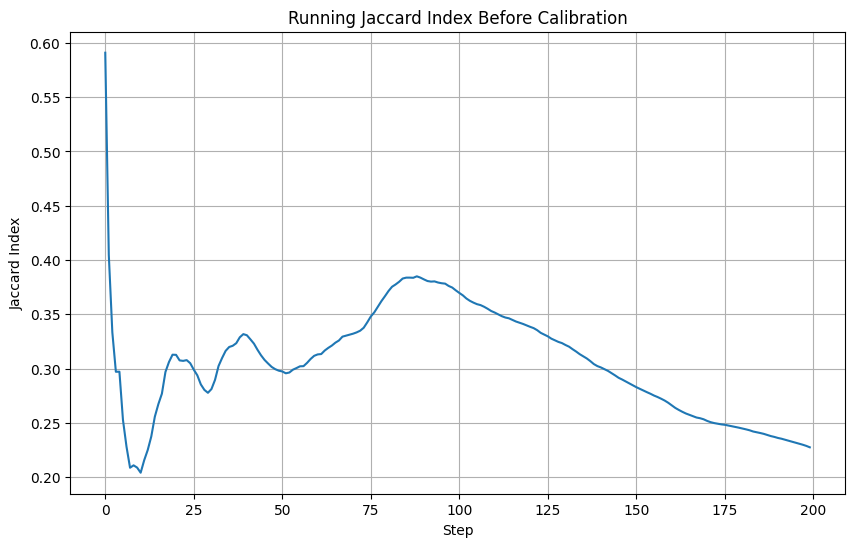

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(len(running_jaccard)), running_jaccard)
plt.title('Running Jaccard Index Before Calibration')
plt.xlabel('Step')
plt.ylabel('Jaccard Index')
plt.grid(True)
plt.show()

![Animation](https://github.com/xiazeyu/PyTorchFire/blob/main/examples/calibration_before.gif?raw=1)

In [20]:
# @title Perform parameter calibration
trainer.train()

100%|██████████| 200/200 [00:02<00:00, 81.35it/s, epoch=2/2, iteration=20/20, step=200/200, loss=0.7736]


In [21]:
# @title Visualize the simulation (after calibration)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# generate calibrated simulation
outputs, running_jaccard = trainer.evaluate()
after_calibration = np.array(outputs)
ground_truth = target[:max_steps]

combined = np.concatenate((np.array(after_calibration), ground_truth), axis=2)

fig, ax = plt.subplots()

im = ax.imshow(combined[0], cmap='hot')
ax.set_title('Left: Calibrated, Right: Target')

def update(frame):
    im.set_array(combined[frame])
    return [im]

ani = FuncAnimation(
    fig, update, frames=len(combined), interval=100, blit=True
)

ani.save('calibration_after.gif', fps=10)
HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

![Animation](https://github.com/xiazeyu/PyTorchFire/blob/main/examples/calibration_after.gif?raw=1)

In [17]:
print(f"a: {trainer.model.a.item():.2f}, c_1: {trainer.model.c_1.item():.2f}, c_2: {trainer.model.c_2.item():.2f}, p_h: {trainer.model.p_h.item():.2f}")

a: 0.00, c_1: 0.00, c_2: 0.00, p_h: 0.15


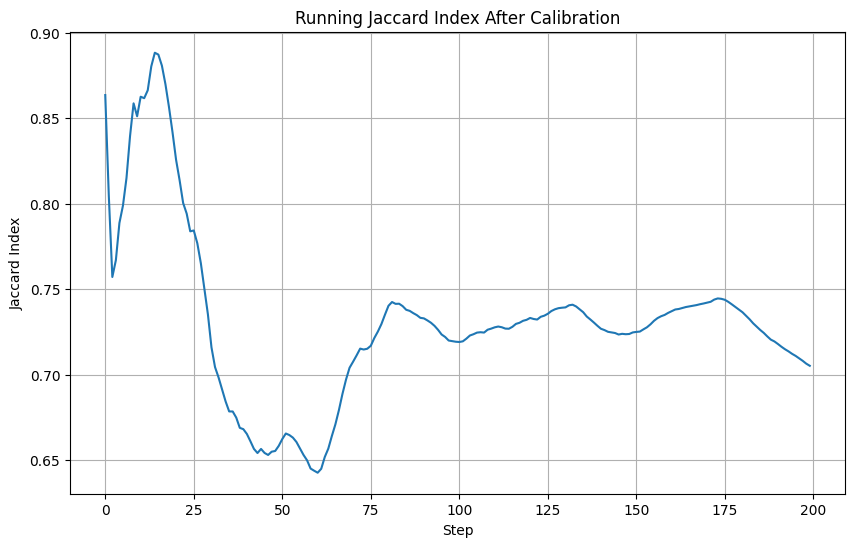

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(running_jaccard)), running_jaccard)
plt.title('Running Jaccard Index After Calibration')
plt.xlabel('Step')
plt.ylabel('Jaccard Index')
plt.grid(True)
plt.show()